In [1]:
# Import LabelEncoder
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


    
"""결측값 처리"""

class MissingValueHandler:
    def __init__(self, dataframe):
        self.df = dataframe

    def fill_missing(self, column_name, method):
        column_data = self.df[column_name]  # 컬럼 데이터 가져오기
        
        if method == 'mean':
            return self.df[column_name].fillna(self.df[column_name].mean())
        elif method == 'median':
            return self.df[column_name].fillna(self.df[column_name].median())
        elif method == 'mode':
            return self.df[column_name].fillna(self.df[column_name].mode()[0])
        elif method == 'zero':
            return self.df[column_name].fillna(0)
        else:
            raise ValueError("지원하지 않는 방법입니다. 'mean', 'median', 'mode', 또는 'zero' 중에서 선택하세요.")

    def drop(self):
        self.df = self.df.dropna()  # 결측값 있는 행을 삭제
        return self.df

    def drop_loc(self):
        self.df = self.df.dropna(axis=1)  # 결측값 있는 열을 삭제
        return self.df

    def get_dataframe(self):
        return self.df  # 현재의 데이터프레임 반환



"""범주형 변수 인코딩" 또는 "레이블 인코딩"""

class CategoricalEncoder:
    def __init__(self, dataframe):
        from sklearn.preprocessing import LabelEncoder
        self.df = dataframe
        self.encoder = LabelEncoder()  # LabelEncoder 객체 생성

    def encode_labels(self):
        categorical_cols = self.df.select_dtypes(include=['object']).columns  # 범주형 열 선택

        for col in categorical_cols:
            self.df.loc[:, col] = self.encoder.fit_transform(self.df[col])  # .loc를 사용하여 열을 수정

        return self.df


"""스케일링""" 

def scale_data(df_encoded, method='StandardScaler'):
    # 예외 처리: 'StandardScaler' 또는 'MinMaxScaler' 외의 값이면 오류 발생
    if method == 'StandardScaler':
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
    elif method == 'MinMaxScaler':
        from sklearn.preprocessing import MinMaxScale
        scaler = MinMaxScaler()
    else:
        raise ValueError("method 파라미터는 'StandardScaler' 또는 'MinMaxScaler'이어야 합니다.")
    
    # 스케일링을 적용할 컬럼을 찾기
    columns_to_scale = []
    for col in df_encoded.columns:
        # 각 컬럼이 0과 1만 포함하는 경우는 스케일링하지 않음
        if not df_encoded[col].isin([0, 1]).all():
            columns_to_scale.append(col)
    
    # 스케일링할 컬럼만 따로 추출
    df_to_scale = df_encoded[columns_to_scale]
    
    # 해당 컬럼만 스케일링
    if not df_to_scale.empty:
        df_scaled = scaler.fit_transform(df_to_scale)
        df_scaled = pd.DataFrame(df_scaled, columns=columns_to_scale)
        
        # .loc을 사용하여 원본 DataFrame에 값을 안전하게 할당
        df_encoded.loc[:, columns_to_scale] = df_scaled
    
    return df_encoded



"""이상치 탐지 함수"""

def detect_outliers(ys, method='outliers_iqr'):
    if method == 'outliers_iqr':
        # IQR 방법
        quartile_1, quartile_3 = np.percentile(ys, [25, 75])
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (iqr * 1.5)
        upper_bound = quartile_3 + (iqr * 1.5)
        return np.where((ys > upper_bound) | (ys < lower_bound))
    
    elif method == 'outliers_z_score':
        # Z-Score 방법
        threshold = 3
        mean_y = np.mean(ys)
        stdev_y = np.std(ys)
        z_scores = [(y - mean_y) / stdev_y for y in ys]
        return np.where(np.abs(z_scores) > threshold)
    
    elif method == 'outliers_modified_z_score':
        # Modified Z-Score 방법
        threshold = 3.5
        median_y = np.median(ys)
        median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
        modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y
                             for y in ys]
        return np.where(np.abs(modified_z_scores) > threshold)
    
    else:
        raise ValueError("잘못된 방법입니다. ['outliers_iqr', 'outliers_z_score', 'outliers_modified_z_score'] 중 하나를 선택해주세요.")


        
"""X. y 분리"""
def split_features_and_target(encoded_df, target_column):
    
    X = encoded_df.drop(columns=[target_column])  # 타겟 열 제외
    y_labels = encoded_df[target_column]  # 타겟 열 선택
    return X, y_labels


# 1. 데이터 전처리
#X = dataset.iloc[:, :-1].values  # 특성
#labels = dataset.iloc[:, -1].values  # 레이블



"""모델 선택"""
class MI:  # ModelInitializer
    def __init__(self, model_type='naive_bayes', **kwargs):
        self.model = self.initialize_model(model_type, **kwargs)
        if X_train is not None and y_train is not None:
            self.fit_model(X_train, y_train)

    def initialize_model(self, model_type, **kwargs):
        """모델 초기화 함수."""
        if model_type == 'GaussianNB':
            from sklearn.naive_bayes import GaussianNB
            model = GaussianNB(**kwargs)  # 지도 분류 / 큰 데이터셋에 적합, 노이즈 데이터 셋 가능
            print("Initialized GaussianNB model (suitable for larger datasets with noise).")
        elif model_type == 'SVM':
            from sklearn.svm import SVC
            model = SVC(**kwargs)  # 지도 분류 / 적은 데이터 적합, 노이즈가 많은 데이터 적은 셋 적합.
        elif model_type == 'DecisionTreeClassifier':
            from sklearn.tree import DecisionTreeClassifier
            model = DecisionTreeClassifier(**kwargs)  # 지도 분류 / 의사 결정 나무
        elif model_type == 'RandomForestRegressor':
            from sklearn.ensemble import RandomForestRegressor
            model = RandomForestRegressor(**kwargs)  # 지도 분류 / 랜덤포레스트
        elif model_type == 'PCA':
            from sklearn.decomposition import PCA
            model = PCA(**kwargs)  # PCA 부분작동
        elif model_type == 'KNeighborsClassifier':
            from sklearn.neighbors import KNeighborsClassifier
            model = KNeighborsClassifier(**kwargs)  # KNN
        elif model_type == 'AgglomerativeClustering':
            from sklearn.cluster import AgglomerativeClustering
            model = AgglomerativeClustering(**kwargs)  # AgglomerativeClustering
        elif model_type == 'DBSCAN':
            from sklearn.cluster import DBSCAN
            model = DBSCAN(**kwargs)  # DBSCAN            
        else:
            raise ValueError("Invalid model type. Choose 'naive_bayes' or 'SVM'.")


        return model
    def fit_model(self, X_train_scaled, y_train_scaled):
        """모델을 학습합니다."""
        self.model.fit(X_train_scaled, y_train_scaled)
        print(f"[{self.model.__class__.__name__}] Model has been fitted.")
        
    def get_model(self):
        """초기화된 모델을 반환합니다."""
        return self.model

def plot_decision_function(X_train, y_train, X_test, y_test, model):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # NumPy 배열에서의 인덱싱
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', marker='o')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors='k', marker='x')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Decision Boundary")
    plt.show()


In [2]:
# 데이터셋 로드
df = sns.load_dataset('titanic')
df_filter = df[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']]

# 결측값 확인
df_filter_check_missing = MissingValueHandler(df_filter)

#MVS.summarize(preprocessing=False)  # Before 상태
print("--- Describe of dtypes column ---")
print(df_filter.describe())
print("--- Sum of dtypes column ---")
print(df_filter_check_missing.df.dtypes)
print("--- Before Fill Missing ---")
print(df_filter_check_missing.df.isnull().sum())

--- Describe of dtypes column ---
         survived      pclass         age       sibsp       parch        fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200
--- Sum of dtypes column ---
survived      int64
pclass        int64
sex          object
age         float64
sibsp         int64
parch         int64
fare        float64
embarked     object
dtype: object
--- Before Fill Missing ---
survived      0
pclass        0
s

In [3]:
# 결측값 처리
MVS = MissingValueHandler(df_filter)
df_filter.loc[:, 'age'] = MVS.fill_missing('age', method='mean')
df_filter.loc[:, 'embarked'] = MVS.fill_missing('embarked', method='mode')
#df_filter.loc[:, '---'] = MVS.fill_missing(df_filter['---'], method='mode')
#df_filter.loc[:, '---'] = MVS.fill_missing(df_filter['---'], method='mode')

#df_filter = MVS.drop()
#df_filter = MVS.drop_loc()

print("--- After Fill Missing ---")
print(df_filter.isnull().sum())

--- After Fill Missing ---
survived    0
pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64


In [4]:
#라벨링
encoder = CategoricalEncoder(df_filter)
df_encoded = encoder.encode_labels()

print(df_encoded)

# 스케일화
df_scaled = scale_data(df_encoded, method='StandardScaler')
#df_scaled = scale_data(df_encoded, method='MinMaxScaler')

print(df_scaled)

     survived  pclass sex        age  sibsp  parch     fare embarked
0           0       3   1  22.000000      1      0   7.2500        2
1           1       1   0  38.000000      1      0  71.2833        0
2           1       3   0  26.000000      0      0   7.9250        2
3           1       1   0  35.000000      1      0  53.1000        2
4           0       3   1  35.000000      0      0   8.0500        2
..        ...     ...  ..        ...    ...    ...      ...      ...
886         0       2   1  27.000000      0      0  13.0000        2
887         1       1   0  19.000000      0      0  30.0000        2
888         0       3   0  29.699118      1      2  23.4500        2
889         1       1   1  26.000000      0      0  30.0000        0
890         0       3   1  32.000000      0      0   7.7500        1

[891 rows x 8 columns]
     survived    pclass sex       age     sibsp     parch      fare  embarked
0           0  0.827377   1 -0.592481  0.432793 -0.473674 -0.502445  0

Initial number of rows before outlier removal: 891
Outlier values in the 'survived' column: Series([], Name: survived, dtype: int64)
Number of outliers detected in the 'survived' column: 0
Outlier values in the 'pclass' column: Series([], Name: pclass, dtype: float64)
Number of outliers detected in the 'pclass' column: 0
Outlier values in the 'age' column: 7     -2.131568
11     2.177876
15     1.947013
16    -2.131568
33     2.793511
         ...   
827   -2.208522
829    2.485693
831   -2.221604
851    3.409146
879    2.023967
Name: age, Length: 66, dtype: float64
Number of outliers detected in the 'age' column: 66
Outlier values in the 'sibsp' column: 24     2.247470
27     2.247470
50     3.154809
59     4.062148
63     2.247470
68     3.154809
71     4.062148
85     2.247470
88     2.247470
159    6.784163
171    3.154809
176    2.247470
180    6.784163
182    3.154809
201    6.784163
229    2.247470
233    3.154809
261    3.154809
266    3.154809
278    3.154809
324    6.784163
3

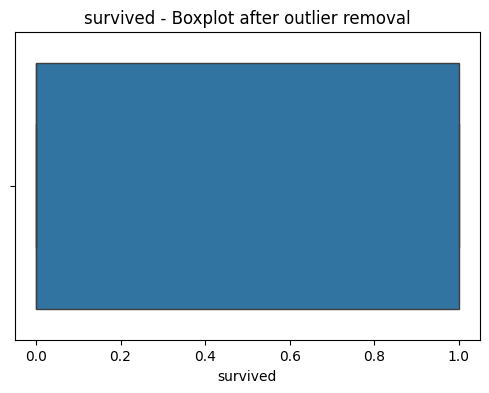

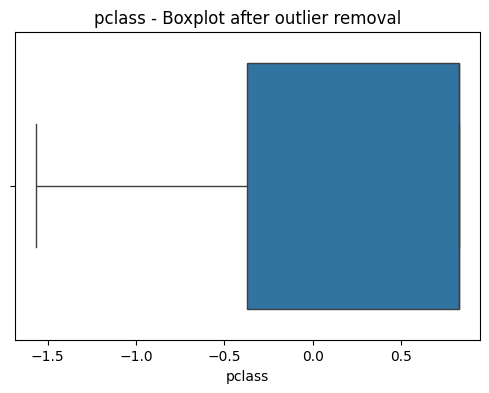

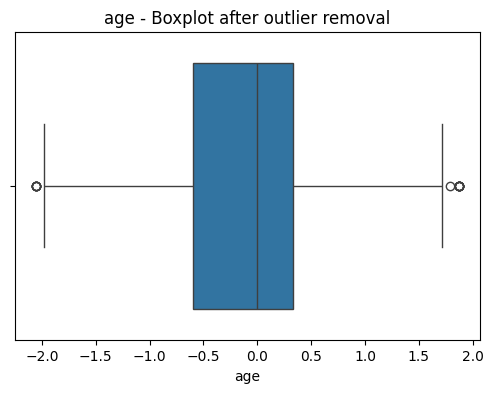

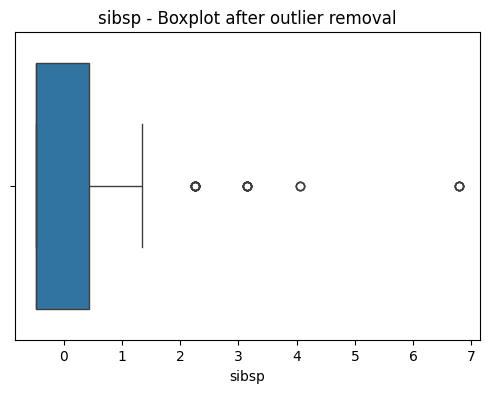

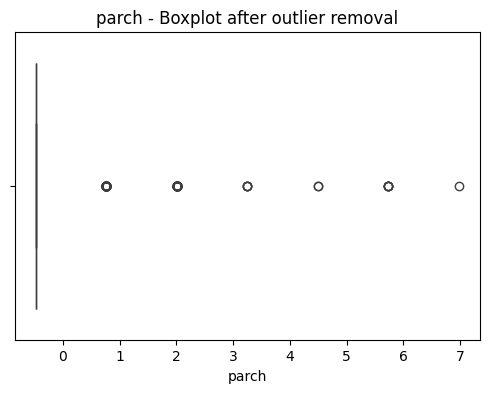

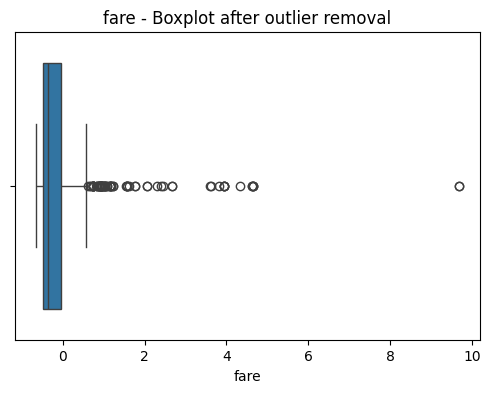


Comparison of row counts before and after outlier removal: 891 -> 581


In [5]:
import matplotlib.pyplot as plt
# IQR 기반 이상치 탐지 함수
outliers_model = 'outliers_iqr'
#outliers_model = 'outliers_z_score'
#outliers_model = 'outliers_modified_z_score' 

# 이상치 제거 전 데이터프레임의 행 수 저장
initial_row_count = df_scaled.shape[0]
print(f"Initial number of rows before outlier removal: {initial_row_count}")

# df_scaled는 이미 스케일링된 데이터프레임입니다
for column in df_scaled.columns:
    if df_scaled[column].dtype in ['int64', 'float64']:  # 숫자형 컬럼만 처리
        # 선택한 모델로 이상치 탐지
        outliers = detect_outliers(df_scaled[column], method=outliers_model)
        
        # 이상치 값 출력
        outlier_values = df_scaled[column].iloc[outliers[0]]
        print(f"Outlier values in the '{column}' column:", outlier_values)
        
        # 이상치 개수 출력
        print(f"Number of outliers detected in the '{column}' column:", len(outliers[0]))

        # 이상치 제거 (이상치가 있는 행을 제거)
        if len(outliers[0]) > 0:  # 이상치가 있을 때만 제거
            valid_outliers = [idx for idx in outliers[0] if idx in df_scaled.index]
            if valid_outliers:  # 유효한 이상치 인덱스만 제거
                df_scaled = df_scaled.drop(valid_outliers)

# 이상치 제거 후 데이터프레임의 행 수
final_row_count = df_scaled.shape[0]
print(f"Final number of rows after outlier removal: {final_row_count}")

# 이상치 제거 후 데이터프레임 출력
print("\nDataframe after outlier removal:")
print(df_scaled_clean)

# 이상치 제거 후 각 컬럼에 대해 박스플롯 시각화
for column in df_scaled_clean.columns:
    if df_scaled_clean[column].dtype in ['int64', 'float64']:  # 숫자형 컬럼만 처리
        plt.figure(figsize=(6, 4))
        sns.boxplot(x=df_scaled_clean[column])
        plt.title(f'{column} - Boxplot after outlier removal')
        plt.show()

# 이상치 제거 전후 행 개수 비교 출력
print(f"\nComparison of row counts before and after outlier removal: {initial_row_count} -> {final_row_count}")

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

X_cross, y_labels_cross = split_features_and_target(df_scaled_clean, 'survived')  # 특징과 타겟 분리

logreg = LogisticRegression()

y_labels_cross = (y_labels_cross >= 0.5).astype(int)
scores = cross_val_score(logreg, X_cross, y_labels_cross, cv=5)
print("교차 검증 점수: ", scores)

교차 검증 점수:  [0.76068376 0.81896552 0.77586207 0.8362069  0.84482759]


In [47]:

# 학습 분리
X, y_labels = split_features_and_target(df_scaled, 'survived')  # 특징과 타겟 분리

from sklearn.linear_model import Lasso

# 모델 초기화 및 훈련
regression = Lasso(alpha=0.1)  # alpha는 λ에 해당
regression.fit(X, y_labels)

coefficients = regression.coef_
print(coefficients)

# 0이 아닌 계수를 가진 feature만 선택
important_features = [i for i in range(len(coefficients)) if coefficients[i] != 0]
print("선택된 feature의 인덱스:", important_features)
selected_column_names = [df_scaled.columns[i] for i in important_features]
print("선택된 feature의 열 이름:", selected_column_names,"전체 컬럼 이름" ,X.columns.tolist())

X_Lasso = X.iloc[:, important_features]
print("선택된 feature의 데이터:\n", X_Lasso)

[-0.08531602 -0.11503384 -0.         -0.          0.          0.
 -0.        ]
선택된 feature의 인덱스: [0, 1]
선택된 feature의 열 이름: ['survived', 'pclass'] 전체 컬럼 이름 ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
선택된 feature의 데이터:
        pclass sex
0    0.827377   1
2    0.827377   0
3   -1.566107   0
4    0.827377   1
5    0.827377   1
..        ...  ..
886 -0.369365   1
887 -1.566107   0
888  0.827377   0
889 -1.566107   1
890  0.827377   1

[581 rows x 2 columns]


X_train 컬럼 갯수 7


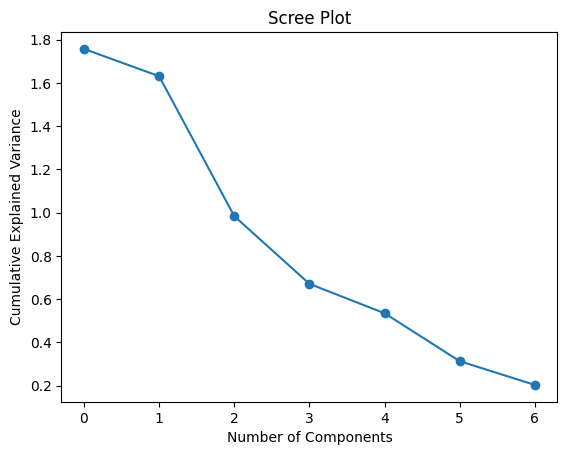

In [78]:
# 학습 분리
X_Lasso, y_labels = split_features_and_target(df_encoded, 'survived')  # 특징과 타겟 분리

X_train, X_test, y_train, y_test = train_test_split(X_Lasso, y_labels, test_size=0.3, random_state=109)

print("X_train 컬럼 갯수", X_train.shape[1])

# PCA 모델 생성
pca_scree_plot = PCA(n_components=X_train.shape[1])
# 훈련 데이터에 PCA 적용
X_train_pca = pca_scree_plot.fit_transform(X_train)

#Scree Plot
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.plot(pca_scree_plot.explained_variance_, 'o-')

In [94]:
from sklearn.decomposition import PCA

# PCA 모델 생성
pca = PCA(n_components=2) 
#pca = PCA(n_components=0.95)  # 전체 분산의 95%를 설명하는 주성분 선택

# 훈련 데이터에 PCA 적용
X_train_pca = pca.fit_transform(X_train)

# 테스트 데이터에 같은 변환을 적용 (주의: fit이 아닌 transform만 사용)
X_test_pca = pca.transform(X_test)

# 변환된 데이터의 크기 확인
print(df_scaled.shape)
print(X_pca.shape)
print(X_pca)
print('\n=================== ================= ===================\n')
# 선택된 주성분의 수
print(f'선택된 주성분의 수: {pca.n_components_}')

# 각 주성분이 설명하는 분산 비율
print(f'각 주성분이 설명하는 분산 비율: {pca.explained_variance_ratio_}')

# 누적 분산 비율
print(f'누적 분산 비율: {pca.explained_variance_ratio_.cumsum()}')
import matplotlib.pyplot as plt
import seaborn as sns



print('\n=================== PCA Result Summary ===================\n')
print('Singular value :\n', pca.singular_values_)
print('\n Singular vector :\n', pca.components_.T)
print('\n Explain Standard deviations  :\n', np.sqrt(pca.explained_variance_))
print('\n Explain Variance Ratio  :\n', pca.explained_variance_ratio_)
print('\n Noise Variance :\n', pca.noise_variance_)




(581, 8)
(581, 2)
[[-1.10782502  0.54138969]
 [-1.02271344 -0.05953448]
 [ 1.12197482 -0.59226029]
 ...
 [ 0.05634828  1.96583213]
 [ 1.18683397 -1.69622462]
 [-0.87724654 -0.55624601]]

=================== ================= ===================

선택된 주성분의 수: 2
각 주성분이 설명하는 분산 비율: [0.9191876  0.05549301]
누적 분산 비율: [0.9191876  0.97468062]

=================== PCA Result Summary ===================

Singular value :
 [20.47305229  5.03036696]

 Singular vector :
 [[ 1.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00]
 [ 0.00000000e+00 -1.48282042e-16]
 [ 0.00000000e+00 -1.21548911e-17]]

 Explain Standard deviations  :
 [2.00754794 0.49326806]

 Explain Variance Ratio  :
 [0.9191876  0.05549301]

 Noise Variance :
 0.05550739514424213


In [96]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
#model = MI(model_type='PCA', n_components=0.95).get_model() #X_model=model.fit_transform(X_train) ??

X_train = X_train_pca
X_test = X_test_pca

# 모델 선택 및 피팅
models = [
    ('GaussianNB', MI(model_type='GaussianNB').get_model()), 
    ('SVM', MI(model_type='SVM', kernel='linear', C=0.1, gamma=0.01).get_model()),# c = 1 하드 0.1 소프트 0.01 베리소프트 , 고차원화 가능
    ('DecisionTree', MI(model_type='DecisionTreeClassifier', random_state=0, max_depth=4).get_model()), # 화이트 박스, 과적합 쉬움 
    ('KNeighbors', MI(model_type='KNeighborsClassifier', n_neighbors=1).get_model())
    
]

# 각 모델에 대해 피팅 및 평가
for model_name, model in models:
    print(f"\n[모델] {model_name}")

    # 모델 학습
    model.fit(X_train, y_train)

    # 예측
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)
    else:
        y_prob = None

    # 정확도 출력
    print(f"훈련 세트 정확도: {model.score(X_train, y_train):.3f}")
    print(f"테스트 세트 정확도: {model.score(X_test, y_test):.3f}")

    # 혼동 행렬 및 분류 리포트
    print("\n혼동 행렬:")
    print(confusion_matrix(y_test, y_pred))
    print("\n분류 리포트:")
    print(classification_report(y_test, y_pred))

    # 확률 예측이 가능한 모델이라면
    if y_prob is not None:
        print(f"\n예측 확률 (예시 - 첫 번째 샘플): {y_prob[0]}")


Initialized GaussianNB model (suitable for larger datasets with noise).
[GaussianNB] Model has been fitted.
[SVC] Model has been fitted.
[DecisionTreeClassifier] Model has been fitted.
[KNeighborsClassifier] Model has been fitted.

[모델] GaussianNB
훈련 세트 정확도: 0.905
테스트 세트 정확도: 0.889

혼동 행렬:
[[19  0  0]
 [ 0  9  4]
 [ 0  1 12]]

분류 리포트:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.90      0.69      0.78        13
           2       0.75      0.92      0.83        13

    accuracy                           0.89        45
   macro avg       0.88      0.87      0.87        45
weighted avg       0.90      0.89      0.89        45


예측 확률 (예시 - 첫 번째 샘플): [2.21498890e-53 7.96514621e-01 2.03485379e-01]

[모델] SVM
훈련 세트 정확도: 0.962
테스트 세트 정확도: 0.978

혼동 행렬:
[[19  0  0]
 [ 0 13  0]
 [ 0  1 12]]

분류 리포트:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
    

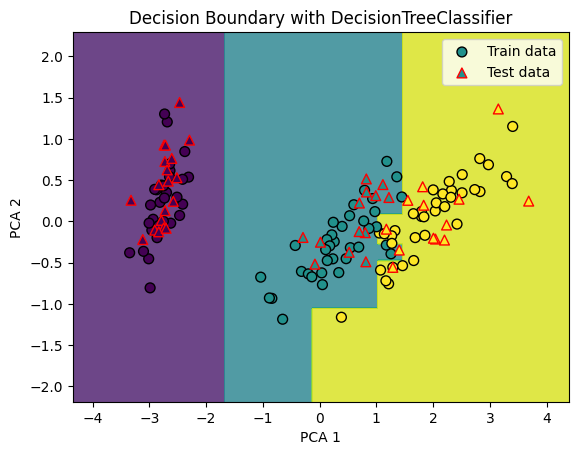

[DecisionTree] 훈련 정확도: 1.000
[DecisionTree] 테스트 정확도: 0.978


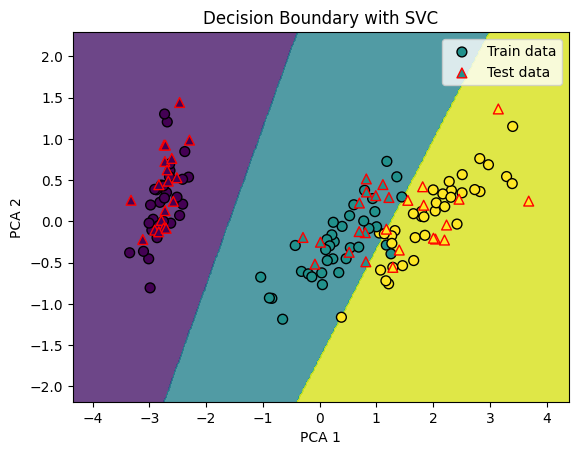

[SVM] 훈련 정확도: 0.962
[SVM] 테스트 정확도: 0.978


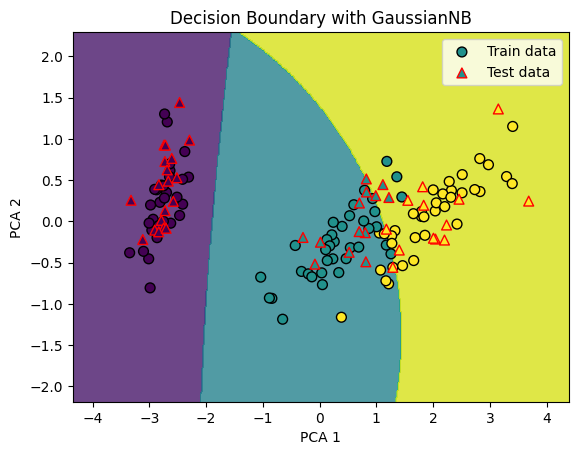

[GaussianNB] 훈련 정확도: 0.905
[GaussianNB] 테스트 정확도: 0.889


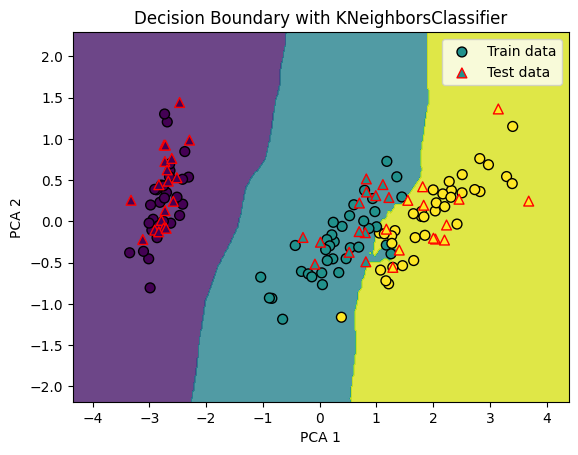

[KNeighbors] 훈련 정확도: 0.990
[KNeighbors] 테스트 정확도: 1.000


In [90]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

def apply_pca_and_train_model(X_train, X_test, y_train, y_test, model_type='DecisionTree', n_components=2):
    """
    PCA를 적용하고, 차원 축소된 데이터로 모델을 훈련시킨 후, 결정 경계를 시각화하는 함수.

    Parameters:
        X_train: 학습용 데이터
        X_test: 테스트용 데이터
        y_train: 학습용 레이블
        y_test: 테스트용 레이블
        model_type: 사용할 모델 유형 ('DecisionTree', 'SVM', 'GaussianNB', 'KNeighbors')
        n_components: PCA에서 사용할 차원 수 (기본 2)
    """

    # PCA로 차원 축소
    pca = PCA(n_components=n_components)
    X_train_2d = pca.fit_transform(X_train)
    X_test_2d = pca.transform(X_test)

    # 모델 선택
    if model_type == 'DecisionTree':
        model = DecisionTreeClassifier()
    elif model_type == 'SVM':
        model = SVC(kernel='linear')
    elif model_type == 'GaussianNB':
        model = GaussianNB()
    elif model_type == 'KNeighbors':
        model = KNeighborsClassifier(n_neighbors=3)
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    # 모델 훈련
    model.fit(X_train_2d, y_train)

    # 테스트 데이터 예측
    y_pred = model.predict(X_test_2d)

    # 결정 경계 시각화
    plot_decision_function(X_train_2d, y_train, X_test_2d, y_test, model)

    # 정확도 출력
    print(f"[{model_type}] 훈련 정확도: {model.score(X_train_2d, y_train):.3f}")
    print(f"[{model_type}] 테스트 정확도: {model.score(X_test_2d, y_test):.3f}")

def plot_decision_function(X_train_2d, y_train, X_test_2d, y_test, model):
    """
    훈련된 모델을 기반으로 결정 경계를 시각화하는 함수.
    
    Parameters:
        X_train_2d: 차원 축소된 훈련 데이터
        y_train: 훈련 데이터 레이블
        X_test_2d: 차원 축소된 테스트 데이터
        y_test: 테스트 데이터 레이블
        model: 훈련된 모델
    """
    h = .02  # mesh step size

    # Define the plot limits
    x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
    y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot decision boundary
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, edgecolors='k', marker='o', s=50, label="Train data")
    plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, edgecolors='r', marker='^', s=50, label="Test data")

    plt.title(f"Decision Boundary with {model.__class__.__name__}")
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.legend()
    plt.show()

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

# 예시 데이터 로드 (이 경우 Iris 데이터셋을 사용)
data = load_iris()
X = data.data
y = data.target

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 각 모델에 대해 PCA 차원 축소 후 학습 및 결정 경계 시각화
models = ['DecisionTree', 'SVM', 'GaussianNB', 'KNeighbors']

for model_name in models:
    apply_pca_and_train_model(X_train, X_test, y_train, y_test, model_type=model_name, n_components=2)


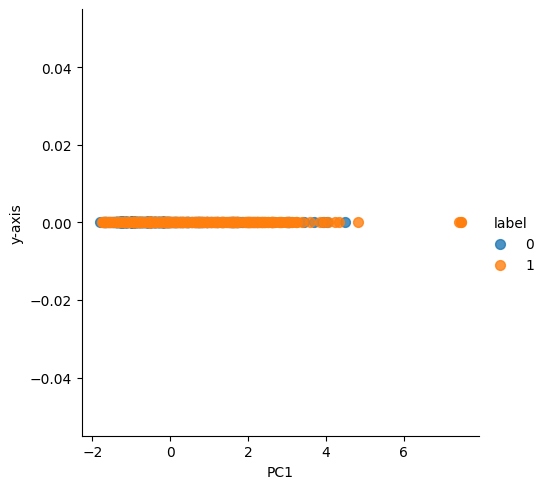

In [185]:
# 학습 분리
X, y_labels = split_features_and_target(df_encoded, 'survived')  # 특징과 타겟 분리

from sklearn import decomposition
pca = decomposition.PCA(n_components=1)
sklearn_pca_x = pca.fit_transform(X)

sklearn_result = pd.DataFrame(sklearn_pca_x, columns=['PC1'])
sklearn_result['y-axis'] = 0.0
sklearn_result['label'] = y_labels

sns.lmplot(x='PC1', y='y-axis', data=sklearn_result, fit_reg=False, 
           scatter_kws={"s": 50}, hue='label')

In [191]:

from sklearn.metrics import confusion_matrix
# 임계값을 설정 (예: 0.2)
threshold = 0.2

# 모델 예측 확률 얻기 (각 모델에 대해 predict_proba가 있는 경우)
for model_name, model in models:
    print(f"\n[모델] {model_name}")

    # 예측 확률 계산 (가능한 경우)
    if hasattr(model, "predict_proba"):
        # 예측 확률 (positive 클래스의 확률)
        y_prob = model.predict_proba(X_test)[:, 1]  # Positive 클래스 확률만 추출
        
        # 커스텀 예측: 임계값을 기준으로 예측을 변경
        y_pred_custom = (y_prob >= threshold).astype(int)  # 확률이 threshold 이상이면 1로 예측

        print(f"\n[커스텀 예측] 임계값 {threshold}으로 예측:")
        print(f"예측 확률 (예시 - 첫 번째 샘플): {y_prob[0]}")
        print(f"커스텀 예측 (임계값 {threshold} 적용): {y_pred_custom}")

        # 혼동 행렬 출력
        print("\n혼동 행렬 (커스텀 예측):")
        print(confusion_matrix(y_test, y_pred_custom))

        # 예측 확률 통계량 출력
        print(f"예측 확률 통계량: Min: {np.min(y_prob)}, Max: {np.max(y_prob)}, Mean: {np.mean(y_prob)}")
    else:
        print(f"모델 {model_name}은 predict_proba 메서드를 지원하지 않습니다.")



[모델] GaussianNB

[커스텀 예측] 임계값 0.2으로 예측:
예측 확률 (예시 - 첫 번째 샘플): 0.8962147812714573
커스텀 예측 (임계값 0.2 적용): [1 1 0 0 0 1 1 0 1 0 0 1 1 0 0 1 0 0 1 1 1 1 1 0 0 1 0 0 0 1 0 0 0 1 0 1 1
 0 0 1 1 1 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 1 0 1 1 1 1 0 0 0 0 1 0 0 0 0 1 0
 0 1 1 1 0 1 0 1 1 0 0 1 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 1 1 1 1 0 1
 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 1 1 0 0 1 1 0 0 0 0 1 0 1 1 1 1
 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 0 1
 1 0 0 0 0 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0
 1 0 0 1 0 0 1 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 1 0 1 1 0
 0 1 1 0 1 0 1 0 0]

혼동 행렬 (커스텀 예측):
[[115  41]
 [ 28  84]]
예측 확률 통계량: Min: 5.437287485219145e-16, Max: 1.0, Mean: 0.38598252766680274

[모델] SVM
모델 SVM은 predict_proba 메서드를 지원하지 않습니다.

[모델] DecisionTree

[커스텀 예측] 임계값 0.2으로 예측:
예측 확률 (예시 - 첫 번째 샘플): 0.9361702127659575
커스텀 예측 (임계값 0.2 적용): [1 1 0 0 0 1 1 0 1 0 0 1 1 0 0 1 0 0 1 1 1 1 1 0 0 1 1 0 0 1 0 0 0 1 0 1 1
 0 0 1 1 